# Libs and Paths


In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import io
import math 
import cv2

from typing import *
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm, trange

# NN
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import STL10

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Distribution, Bernoulli, Normal

sns.set()
sns.set_theme(style="white")
using_cpu = False

# Dataset

In [ ]:
def pixalate_image(image, scale_percent = 20):
  init_dim = (image.shape[1], image.shape[0])
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)  
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

  # scale back to original size
  low_res_image = cv2.resize(small_image, init_dim, interpolation =  cv2.INTER_AREA) 
  return low_res_image, image

In [ ]:
class STL10dataset(STL10):
  def __getitem__(self, index:int):
    img = self.data[index]

    img, target = pixalate_image(np.transpose(img, (1, 2, 0)))

    if self.transform is not None:
        img = self.transform(img)

    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target


In [ ]:
def scatterplot(outputs, targets, xlabel='', ylabel=''):
  plt.figure(figsize=(4,5))
  plt.plot(outputs, targets, 'ko')
  plt.plot(range(min(targets), max(targets)), range(min(targets), max(targets)), '--', linewidth=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

def plot_loss(out_dict):
  n = range(0, len(out_dict['train_loss']))
  plt.figure(figsize=(4,5))
  plt.plot(n, out_dict['train_loss'], label='Train loss')
  plt.plot(n, out_dict['test_loss'], label='Test loss')
  plt.legend()
  plt.show()

def plot_batch(loader):
  # Load a batch of images into memory
  images, labels = next(iter(loader))

  plt.figure(figsize=(20,10))
  for i in range(16):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.title('age:' + str(labels[i].item()))
    plt.axis('off')
  plt.show()

def imshow(img):
  """ show an image """
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def make_grid(loader):
  images, labels = next(iter(loader))

  imshow(torchvision.utils.make_grid(images))
  # print labels
  print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

def plot_forward_pass(loader, model, device='cpu'):
  images, labels = next(iter(loader))
  images = images.to(device)
  preds = model(images)
  
  if device != 'cpu':
    preds = preds.cpu().detach().numpy()
    labels = labels.detach().numpy()

  scatterplot(preds, labels, xlabel='Predictions', ylabel='Targets')


# Neural Networks

##Convolutional Neural Network

In [ ]:
class ConvNN(nn.Module):
    def __init__(self, flatten=False):
        super().__init__()
        self.flatten = flatten
        # self.convolutional = nn.Sequential(
        #         nn.Conv2d(3, 10, 3, stride=1, padding=1),
        #         nn.LeakyReLU(),
            
        #         nn.Conv2d(10, 16, 3, stride=1, padding=1),
        #         nn.BatchNorm2d(16),
        #         nn.LeakyReLU(),
            
        #         nn.Conv2d(16, 32, 3, stride=1, padding=1),
        #         nn.BatchNorm2d(32),
        #         nn.LeakyReLU(),
            
        #         nn.Conv2d(32, 32, 5, stride=1),
        #         nn.LeakyReLU(),
        # )

        self.convolutional = nn.Sequential(
                  nn.Conv2d(3, 64, 3, stride=1, padding=1),
                  nn.LeakyReLU(),
              
                  nn.Conv2d(64, 32, 3, stride=1, padding=1),
                  nn.LeakyReLU(),
              
                  nn.Conv2d(32, 16, 3, stride=1, padding=1),
                  nn.LeakyReLU(),
              
                  nn.Conv2d(16, 3, 3, stride=1, padding=1),
                  nn.LeakyReLU(),
        )
        self.convolutional.apply(self.init_weights)
        
        # self.fully_connected = nn.Sequential(
        #         nn.Linear(128, 16),
        #         nn.LeakyReLU(),
        #         nn.Linear(16, 1)
        # )          
    
    def init_weights(m, _):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight, gain=nn.init.calculate_gain('leaky_relu'))
            m.bias.data.fill_(0.01)
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)
    
    def forward(self, x):
        _shape = x.shape
        x = self.convolutional(x)
        x = x.view(_shape)
        #reshape x so it becomes flat
        # x = x.view(x.size(0), -1)
        # x = self.fully_connected(x)
        if self.flatten:
            x = torch.flatten(x)
        return x

# Setup

In [ ]:
from skimage.metrics import structural_similarity as ssim

def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


def compare_images(target, ref):  
    return (psnr(target, ref), ssim(target, ref, multichannel =True))

## Data

In [ ]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.25),
    #transforms.RandomPerspective(p=0.25),
    #transforms.ColorJitter(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

# transforms for test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# transforms for original image
target_transform = transforms.Compose([
                                transforms.ToTensor(),
                            ])

In [ ]:
# train and validation data
train_data = STL10dataset(
    root='/content/drive/MyDrive/DTU/DL/Deep_Learning/Data/',
    split = 'train',
    download=True,
    transform=train_transform,
    target_transform=target_transform
)

val_data = STL10dataset(
    root='/content/drive/MyDrive/DTU/DL/Deep_Learning/Data/',
    split = 'test',
    download=True,
    transform=test_transform,
    target_transform=target_transform
)

Using downloaded and verified file: /content/drive/MyDrive/DTU/DL/Deep_Learning/Data/stl10_binary.tar.gz
Extracting /content/drive/MyDrive/DTU/DL/Deep_Learning/Data/stl10_binary.tar.gz to /content/drive/MyDrive/DTU/DL/Deep_Learning/Data/
Files already downloaded and verified


In [ ]:
 # Split data into validation and test
test_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4)), len(val_data)))
val_data = torch.utils.data.Subset(val_data, range(int(np.floor(len(val_data)*0.4))))

In [ ]:
batch_size = 64

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valoader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

In [ ]:
print('Training Samples: {}'.format(len(trainloader.dataset)))
print('Validation Samples: {}'.format(len(valoader.dataset)))
print('Test Samples: {}'.format(len(testloader.dataset)))

Training Samples: 5000
Validation Samples: 3200
Test Samples: 4800


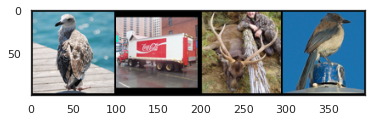

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(labels[:4]))


In [ ]:
images[0].shape

torch.Size([3, 96, 96])

## Network

In [ ]:
num_epochs = 80
lr = 0.00005
weight_decay = 0.1

model = ConvNN()
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
model_descr = 'Baseline CNN with Batchnorm and Linear output'
model_dir = '/content/drive/MyDrive/DTU/DL/Deep_Learning/Notebooks/Output/Models/'
model_name = 'cnn.pt'

def save_model(model):
  torch.save(model.state_dict(), model_dir + model_name)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

>> Using device: cuda:0


In [ ]:
def train(model, loss_fun, optimizer, train_loader, test_loader, num_epochs=10):

    # move the model to the device
    model = model.to(device)

    out_dict = {'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output.float(), target.float())
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())

        #Compute the test accuracy
        test_loss = []
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            batch_loss = loss_fun(output.float(), target.float()).cpu().item()
            test_loss.append(batch_loss)
            
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t")
        plot_loss(out_dict)
    return out_dict

  0%|          | 0/80 [00:00<?, ?epoch/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.211	 test: 0.167	


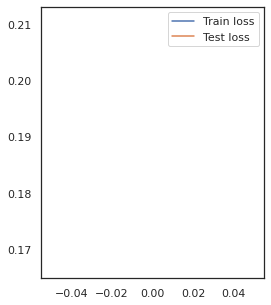

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.068	 test: 0.022	


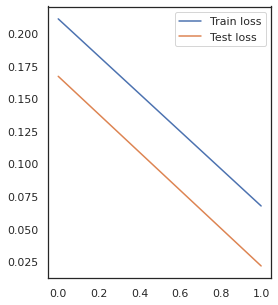

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.020	 test: 0.018	


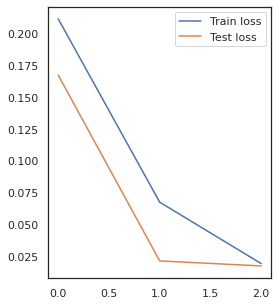

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.016	 test: 0.015	


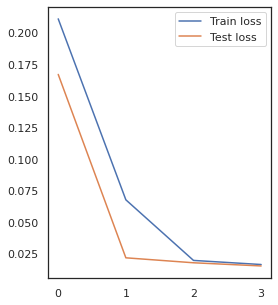

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.014	 test: 0.014	


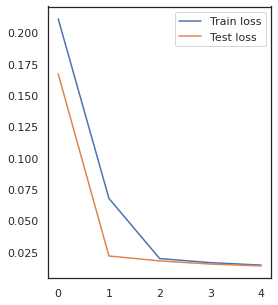

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.013	 test: 0.013	


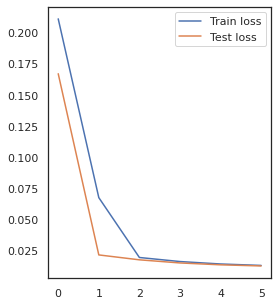

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.012	 test: 0.012	


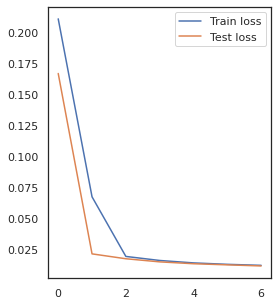

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.012	 test: 0.011	


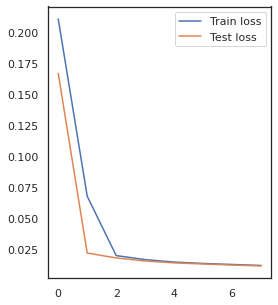

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.011	 test: 0.011	


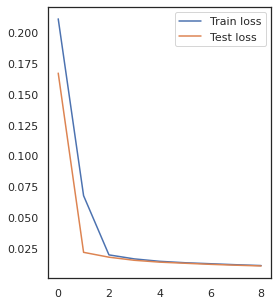

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.011	 test: 0.010	


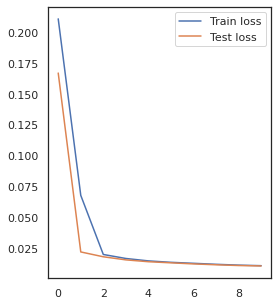

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.010	


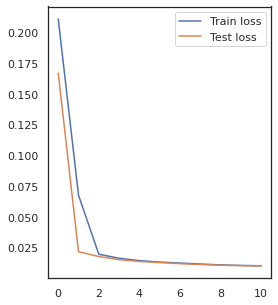

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.010	


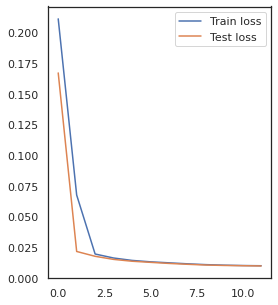

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.010	


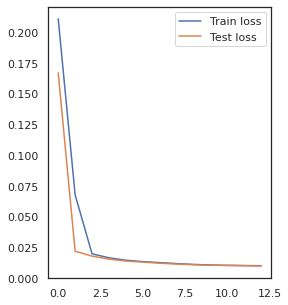

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.010	


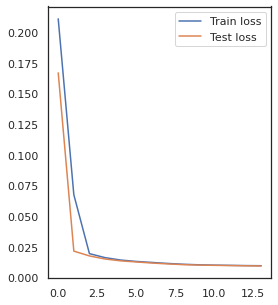

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.009	


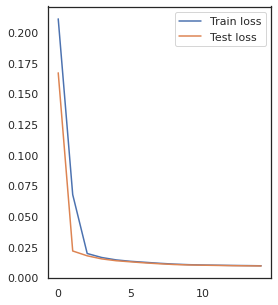

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.010	 test: 0.009	


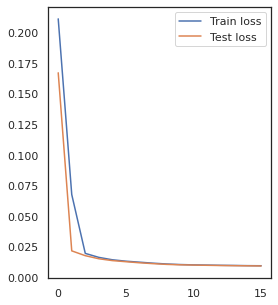

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


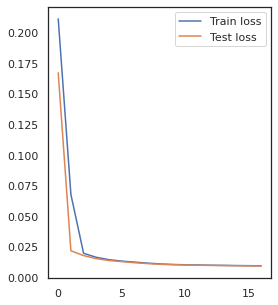

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


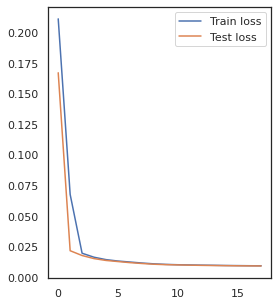

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


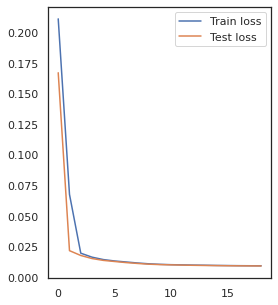

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


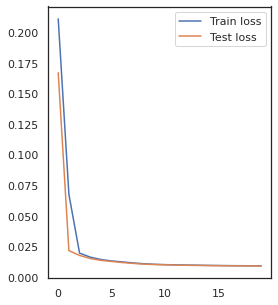

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


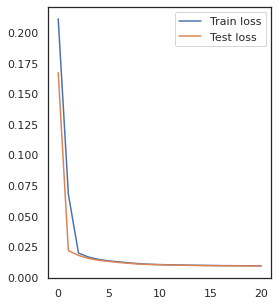

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


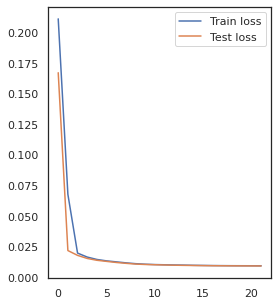

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


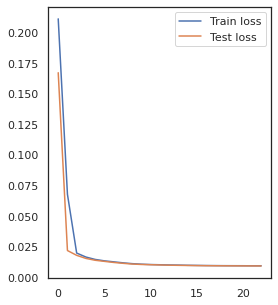

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


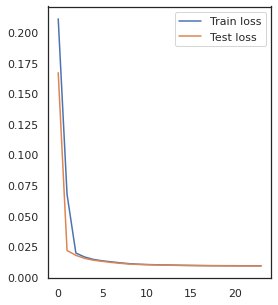

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


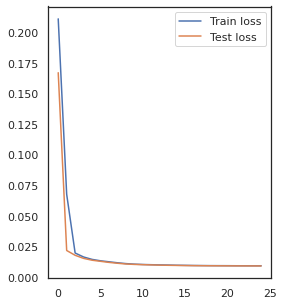

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


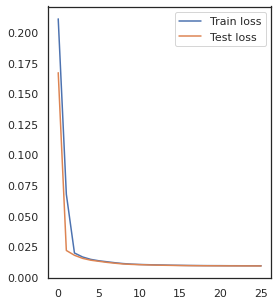

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


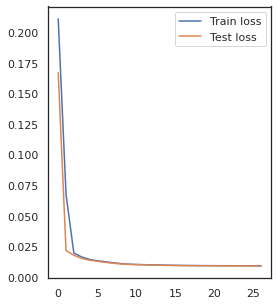

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


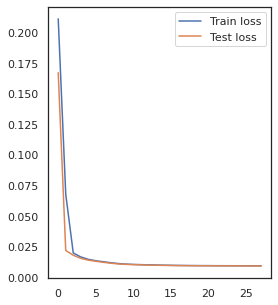

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


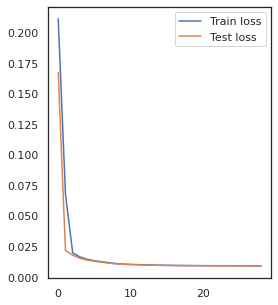

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


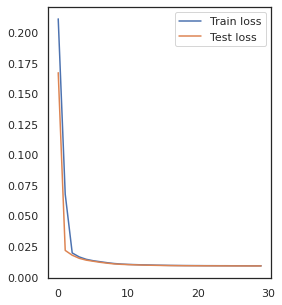

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


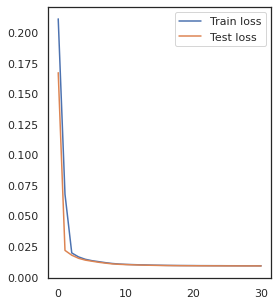

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


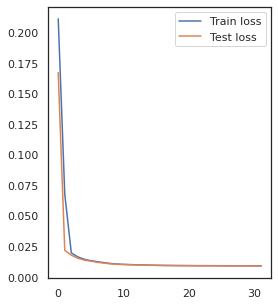

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


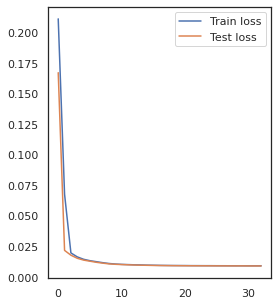

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


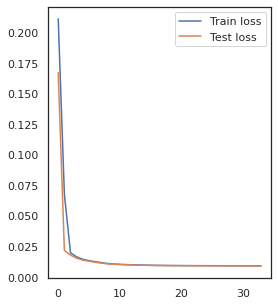

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


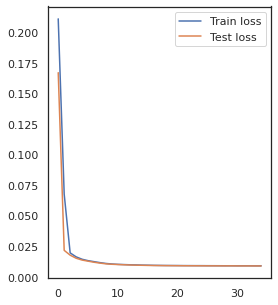

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


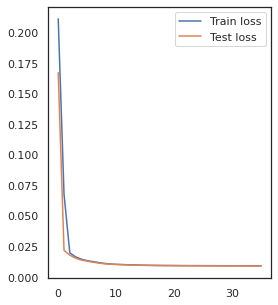

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


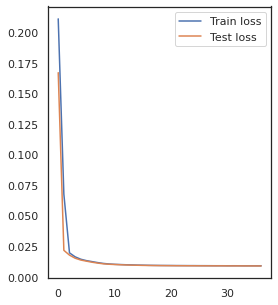

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


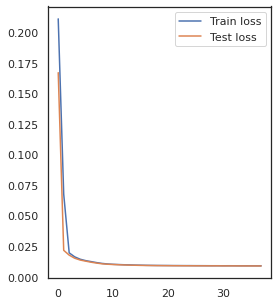

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


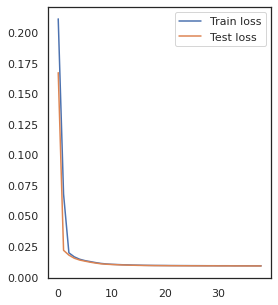

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


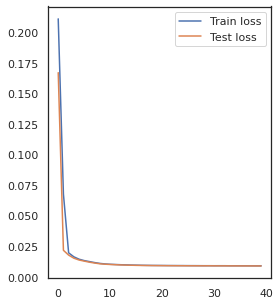

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


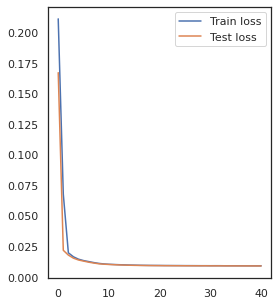

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


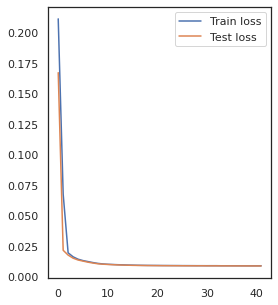

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


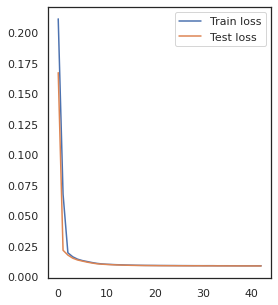

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


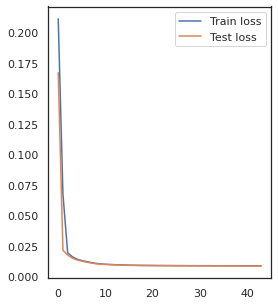

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


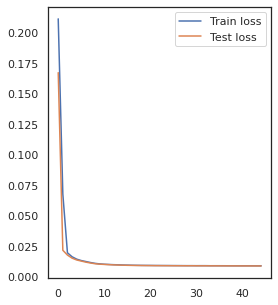

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


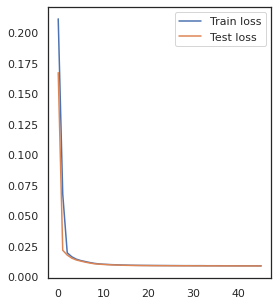

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


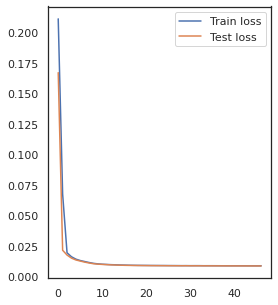

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


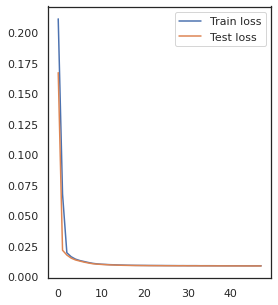

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


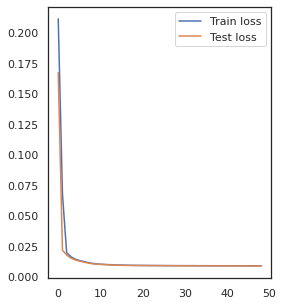

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


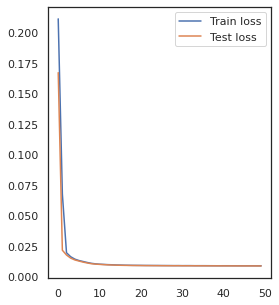

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


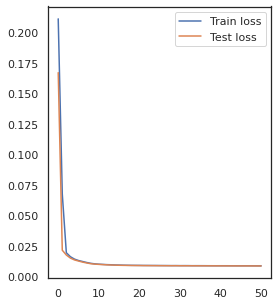

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


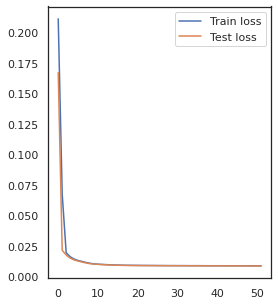

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


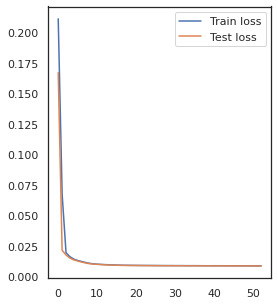

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


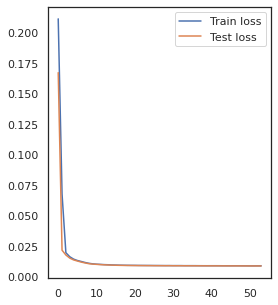

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


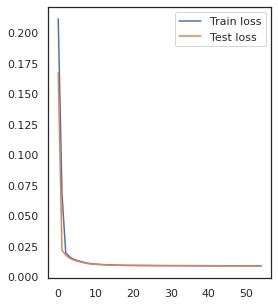

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


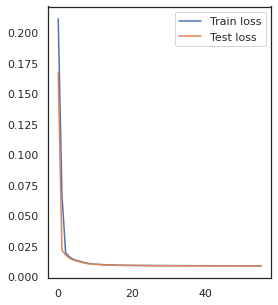

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


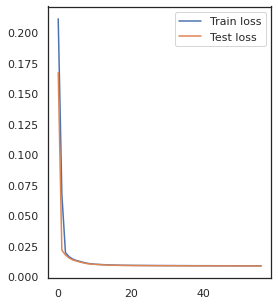

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


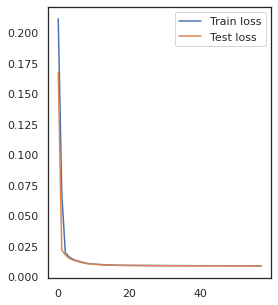

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


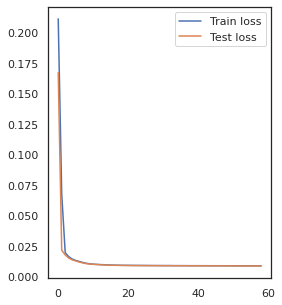

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


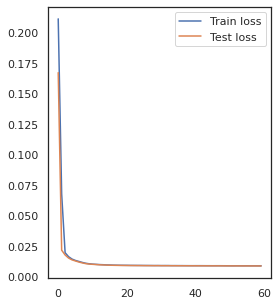

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


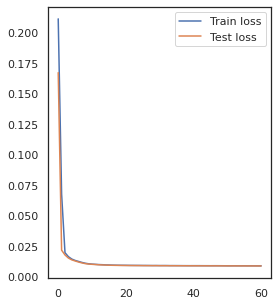

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


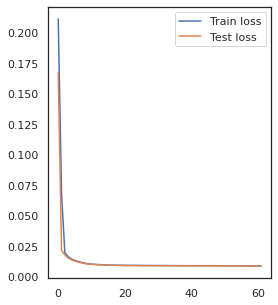

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


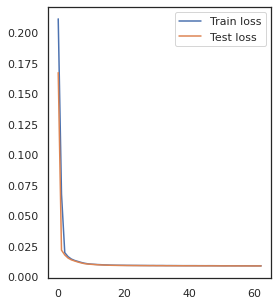

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


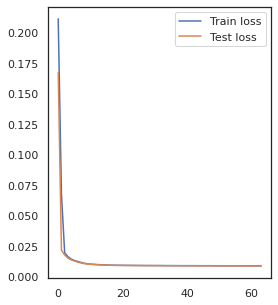

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


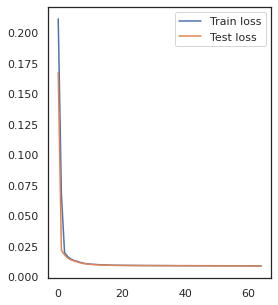

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


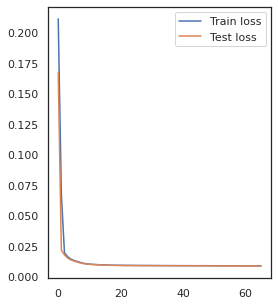

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


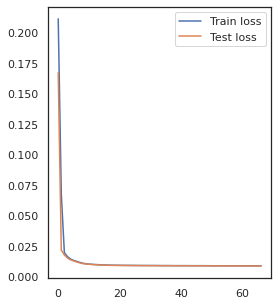

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


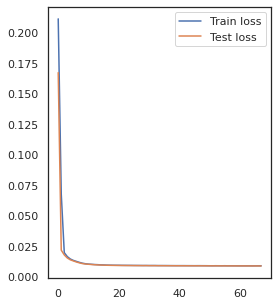

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


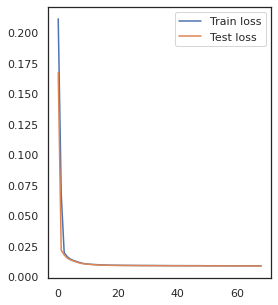

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


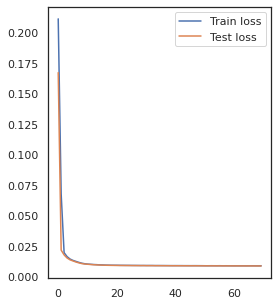

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


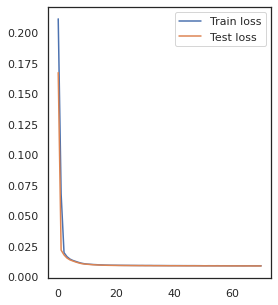

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


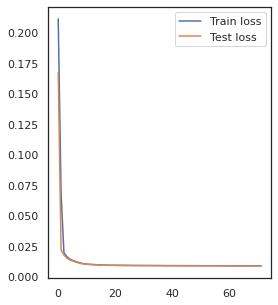

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


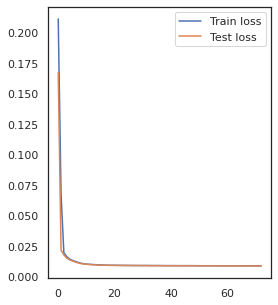

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


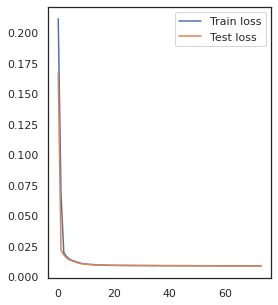

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


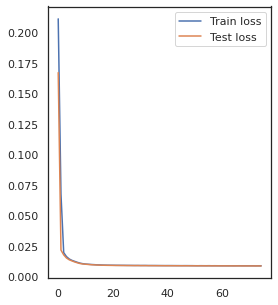

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


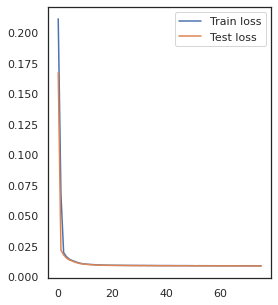

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


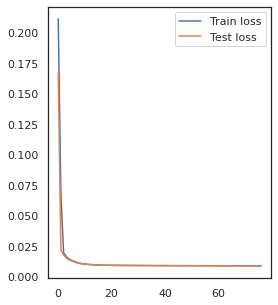

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


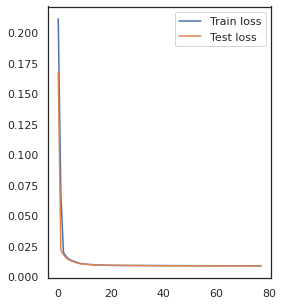

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


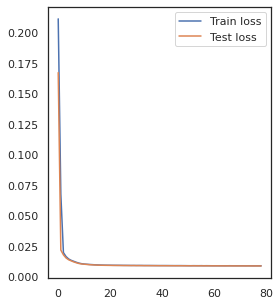

  0%|          | 0/79 [00:00<?, ?it/s]

Loss train: 0.009	 test: 0.009	


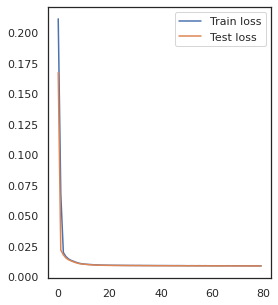

In [ ]:
out_dict = train(model, loss_fun, optimizer, trainloader, valoader, num_epochs)

In [ ]:
def test(model, loss_fun, test_loader):
  loss = []
  psnr = []
  ssim = []
  model.eval()
  for data, target in tqdm(test_loader):
      data, target = data.to(device), target.to(device)
      with torch.no_grad():
          output = model(data)
      batch_loss = loss_fun(output, target).cpu().item()
      loss.append(batch_loss)

      dims = (target.shape[2], target.shape[3], target.shape[1])

      _psnr, _ssim = compare_images(output.cpu().view(dims).numpy(), target.cpu().view(dims).numpy())
      psnr.append(_psnr)
      ssim.append(_ssim)
  return (loss, psnr, ssim)          

In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                          shuffle=False, num_workers=2)

test_loss, test_psnr, test_ssim = test(model, loss_fun, testloader)

  0%|          | 0/4800 [00:00<?, ?it/s]

In [ ]:
np.mean(test_loss), np.mean(test_psnr), np.mean(test_ssim)

(0.008864745686757184, 69.23446917456126, 0.8091238286304686)

In [ ]:
def metrics_on_loader(dataloader):
    psnr_running_loss = 0.0
    ssim_running_loss = 0.0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, high_res = data
            data = data.cpu()
            high_res = high_res.cpu()
            
            _psnr, _ssim = compare_images(high_res.view((high_res.size(2), high_res.size(3), high_res.size(1))).numpy(), data.view((data.size(2), data.size(3), data.size(1))).numpy())
            
            psnr_running_loss += _psnr
            ssim_running_loss += _ssim            
            
    psnr = psnr_running_loss/len(dataloader.dataset)
    ssim = ssim_running_loss/len(dataloader.dataset)

    return psnr, ssim


In [ ]:
metrics_on_loader(testloader)

  0%|          | 0/3200 [00:00<?, ?it/s]

(68.47608740126803, 0.7807224785155209)

In [ ]:
save_model(model)

In [ ]:
import pickle
with open('out_dict.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Forward Pass

In [ ]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                          shuffle=True, num_workers=2)

In [ ]:
model.load_state_dict(torch.load(model_dir + model_name))

<All keys matched successfully>

In [ ]:
degraded, ref = next(iter(testloader))
output = model(degraded)

In [ ]:
ref = ref.squeeze()
degraded = degraded.squeeze()
output = output.detach().squeeze()

In [ ]:
print(torch.min(output))

tensor(-0.0080)


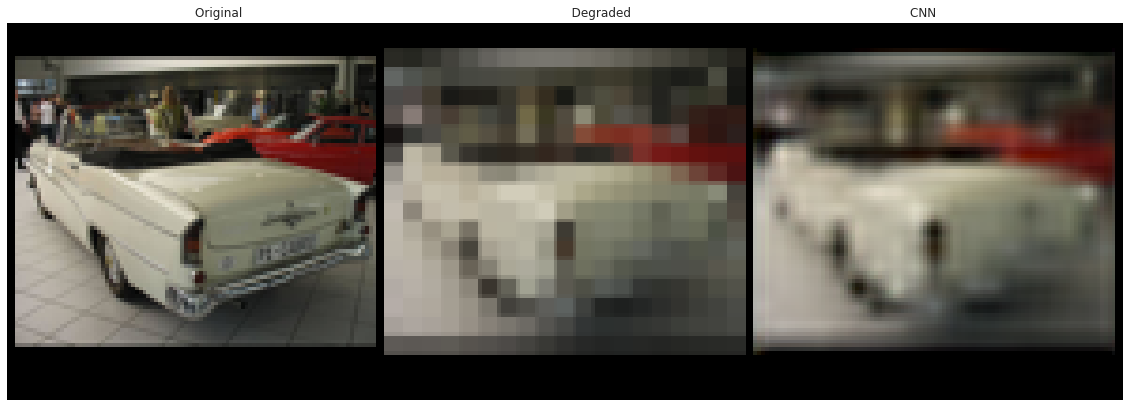

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Original                                                                                     Degraded                                                                        CNN')
    plt.axis('off')
    plt.show()

# show images
imshow(torchvision.utils.make_grid([ref, degraded, output]))